In [188]:
import numpy as np
import pandas as pd
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [186]:
import warnings
warnings.filterwarnings('ignore')

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [191]:
df = pd.read_csv('data.csv', encoding='utf-8')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [192]:
df['recency'] = df['recency'].astype('str')
df['used_discount'] = df['used_discount'].astype('str')
df['used_bogo'] = df['used_bogo'].astype('str')
df['zip_code'] = df['zip_code'].astype('str')
df['is_referral'] = df['is_referral'].astype('str')

In [193]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [194]:
df['treatment'].replace(to_replace={'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1}, inplace=True)

In [195]:
index_train, index_valid = train_test_split(df.index, test_size=0.3, random_state=43)
index_train.shape, index_valid.shape

((44800,), (19200,))

In [196]:
X_train = df.loc[index_train, :].drop(['target', 'treatment'], 1)
y_train = df.loc[index_train, 'target']
treat_train = df.loc[index_train, 'treatment']

X_valid = df.loc[index_valid, :].drop(['target', 'treatment'], 1)
y_valid = df.loc[index_valid, 'target']
treat_valid = df.loc[index_valid, 'treatment']

print(X_train.shape, y_train.shape, treat_train.shape)
print(X_valid.shape, y_valid.shape, treat_valid.shape)

(44800, 7) (44800,) (44800,)
(19200, 7) (19200,) (19200,)


Создадим признаков.

In [198]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']

In [199]:
num_features = [col for col in X_train.columns if X_train[col].dtype == 'float64']

In [200]:
#попарная конъюнкция
def new_cat_features(data, features):
    for i, col1 in enumerate(features):
        for j, col2 in enumerate(features[i + 1:]):
            data[col1 + '_' + col2] = data[col1] + '_' + data[col2]    

In [201]:
#простые статистики и функции
def new_num_features(data, features):
    for col in features:
        data[col + 'min'] = np.min(data[col])
        data[col + 'max'] = np.max(data[col])
        data[col + 'square'] = np.power(data[col], 2)
        data[col + 'cube'] = np.power(data[col], 3)
        data[col + 'median'] = np.median(data[col])
        data[col + 'log'] = np.log(data[col])
        data[col + '25perc'] = np.percentile(data[col], 25)
        data[col + '75perc'] = np.percentile(data[col], 75)
        data[col + 'std'] = np.std(data[col])

In [202]:
new_cat_features(X_train, cat_features)

In [203]:
new_cat_features(X_valid, cat_features)

In [204]:
new_num_features(X_train, num_features)

In [205]:
new_num_features(X_valid, num_features)

In [206]:
print(X_train.shape, X_valid.shape)

(44800, 31) (19200, 31)


In [207]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,recency_used_discount,recency_used_bogo,recency_zip_code,...,is_referral_channel,historymin,historymax,historysquare,historycube,historymedian,historylog,history25perc,history75perc,historystd
53762,1,50.56,1,0,Rural,1,Phone,1_1,1_0,1_Rural,...,1_Phone,29.99,3345.93,2556.3136,1.292472e+05,158.61,3.923161,65.5175,327.0075,257.440704
27293,9,44.42,1,0,Urban,1,Web,9_1,9_0,9_Urban,...,1_Web,29.99,3345.93,1973.1364,8.764672e+04,158.61,3.793690,65.5175,327.0075,257.440704
3476,8,29.99,1,0,Surburban,1,Web,8_1,8_0,8_Surburban,...,1_Web,29.99,3345.93,899.4001,2.697301e+04,158.61,3.400864,65.5175,327.0075,257.440704
24877,5,312.00,0,1,Surburban,1,Phone,5_0,5_1,5_Surburban,...,1_Phone,29.99,3345.93,97344.0000,3.037133e+07,158.61,5.743003,65.5175,327.0075,257.440704
16812,2,74.93,0,1,Urban,1,Phone,2_0,2_1,2_Urban,...,1_Phone,29.99,3345.93,5614.5049,4.206949e+05,158.61,4.316554,65.5175,327.0075,257.440704


In [208]:
new_cat = [col for col in X_train.columns if X_train[col].dtype == 'object']

In [209]:
uplift_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

Solo модель.

In [210]:
sm = SoloModel(CatBoostClassifier(n_estimators=300, max_depth=3, random_state=43, silent=True))
sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': new_cat})
uplift_sm = sm.predict(X_valid)

In [211]:
sm_score_10 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.3)

In [212]:
uplift_results['approach'].append('SoloModel')
uplift_results['uplift@10%'].append(sm_score_10)
uplift_results['uplift@20%'].append(sm_score_20)
uplift_results['uplift@30%'].append(sm_score_30)

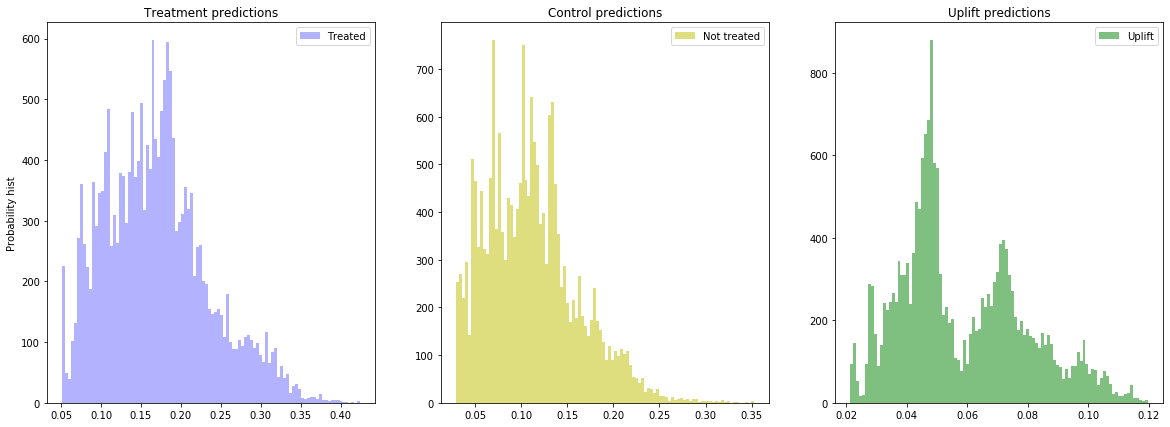

In [99]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посчитаем среднюю конверсию.

In [264]:
uplift_sm = pd.DataFrame(uplift_sm, columns=['uplift_sm'])
uplift_sm.head()

,uplift_sm
0,0.068436
1,0.071196
2,0.044101
3,0.059817
4,0.070780


In [265]:
conversion = pd.merge(y_valid, uplift_sm, left_index=True, right_index=True).reset_index()
conversion.head()

,index,target,uplift_sm
0,12681,1,0.058514
1,11469,0,0.068855
2,8671,1,0.048233
3,18731,0,0.095704
4,5379,1,0.089610


In [266]:
#сортировка по аплифт по убыванию.
conversion.sort_values(by=['uplift_sm'], inplace=True)
conversion.head()

,index,target,uplift_sm
4844,10087,0,0.021340
2360,963,1,0.021691
4939,14257,0,0.021691
1890,7020,0,0.021691
4634,751,0,0.021691


In [267]:
#разбивка на децили
conversion['Decile_rank'] = pd.qcut(conversion['uplift_sm'], 10, 
                            labels = False)
conversion.head()

,index,target,uplift_sm,Decile_rank
4844,10087,0,0.021340,0
2360,963,1,0.021691,0
4939,14257,0,0.021691,0
1890,7020,0,0.021691,0
4634,751,0,0.021691,0


In [268]:
conversion['Decile_rank'].value_counts()

3    580
0    579
8    578
6    576
2    576
7    575
5    575
9    574
1    574
4    571
Name: Decile_rank, dtype: int64

Посмотрим на среднюю конверсию по верхнему, среднему и нижнему децилям.

In [271]:
conversion.groupby('Decile_rank')['target'].mean()

Decile_rank
0    0.148532
1    0.111498
2    0.119792
3    0.139655
4    0.143608
5    0.140870
6    0.175347
7    0.121739
8    0.159170
9    0.144599
Name: target, dtype: float64

Модель трансформации классов.

In [102]:
ct = ClassTransformation(CatBoostClassifier(n_estimators=300, max_depth=3, random_state=43, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': new_cat})
uplift_ct = ct.predict(X_valid)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


In [105]:
ct_score_10 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.3)

In [106]:
uplift_results['approach'].append('ClassTransformation')
uplift_results['uplift@10%'].append(ct_score_10)
uplift_results['uplift@20%'].append(ct_score_20)
uplift_results['uplift@30%'].append(ct_score_30)

Две независимые модели.

In [109]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(n_estimators=300, max_depth=3, random_state=43, silent=True), 
    estimator_ctrl=CatBoostClassifier(n_estimators=300, max_depth=3, random_state=43, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': new_cat}, 
    estimator_ctrl_fit_params={'cat_features': new_cat}
)

uplift_tm = tm.predict(X_valid)

In [112]:
tm_score_10 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.3)

In [113]:
uplift_results['approach'].append('TwoModels')
uplift_results['uplift@10%'].append(tm_score_10)
uplift_results['uplift@20%'].append(tm_score_20)
uplift_results['uplift@30%'].append(tm_score_30)

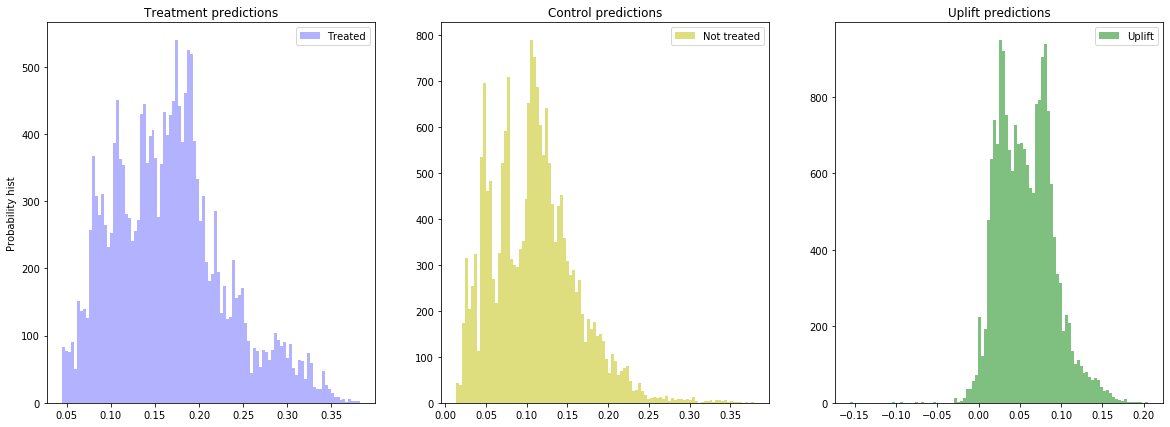

In [115]:
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на итоговые результаты.

In [114]:
results = pd.DataFrame(uplift_results).set_index('approach')
results

,uplift@10%,uplift@20%,uplift@30%
approach,,,
SoloModel,0.119744,0.070147,0.069465
ClassTransformation,0.092401,0.076394,0.066865
TwoModels,0.098628,0.072461,0.071529
